<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/machine%20translation/Attention_based_Sequence_to_Sequence_Models_for_Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import input, range

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import urllib

TensorFlow 2.x selected.


In [4]:
try:
  print("Uploading...")
  from google.colab import files
  files.upload()
  print("File uploaded successfully.")
except Exception as ex:
  print(ex)

Uploading...


Saving spa-eng.zip to spa-eng.zip
File uploaded successfully.


In [5]:
import zipfile
with zipfile.ZipFile("spa-eng.zip",mode='r') as zf:
  zf.printdir() 
  print('Extracting all the files now...') 
  zf.extractall()
  print('Done!')
!ls -GFlash --color

File Name                                             Modified             Size
_about.txt                                     2020-01-11 23:49:12         1441
spa.txt                                        2020-01-11 23:49:12     18432706
Extracting all the files now...
Done!
total 23M
4.0K drwxr-xr-x 1 root 4.0K Feb  3 06:48 ./
4.0K drwxr-xr-x 1 root 4.0K Feb  3 06:43 ../
4.0K -rw-r--r-- 1 root 1.5K Feb  3 06:48 _about.txt
4.0K drwxr-xr-x 1 root 4.0K Jan 16 16:43 .config/
4.0K drwxr-xr-x 1 root 4.0K Jan 13 16:38 sample_data/
4.6M -rw-r--r-- 1 root 4.6M Feb  3 06:46 spa-eng.zip
 18M -rw-r--r-- 1 root  18M Feb  3 06:48 spa.txt


In [6]:
with open('spa.txt',mode='rb') as t:
  print(t.read(10))

b'Go.\tVe.\tCC'


In [0]:
%tensorflow_version 2.x
import os, sys
import gc
gc.enable()

import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding, \
Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [0]:
def softmax_over_time(x):
  assert(K.ndim(x)>2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s 

In [0]:
BATCH_SIZE = 64
# BATCH_SIZE = 128
# BATCH_SIZE = 256
# BATCH_SIZE = 512

EPOCHS = 100

# LATENT_DIM = 512
LATENT_DIM = 1024
# LATENT_DIM = 2056

NUM_SAMPLES = 15000
MAX_SEQUENCE_LEGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

In [0]:
input_texts = []
target_texts = []
target_texts_inputs = []

In [12]:
#load in the data
t = 0
for line in open('spa.txt'):
  t+= 1
  if t>NUM_SAMPLES:
    print('Max Samples Exceeded. Breaking out of loop.')
    break
  if '\t' not in line:
    continue
  input_text, translation = line.split('\t')[:-1]
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation 

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples: ",len(input_texts))

Max Samples Exceeded. Breaking out of loop.
num samples:  15000


In [0]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [14]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.'% len(word2idx_inputs))

Found 3135 unique input tokens.


In [0]:
max_len_input = max(len(x) for x in input_sequences)

In [0]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [17]:
word2idx_outputs = tokenizer_outputs.word_index 
print('Found %s unique output tokens.'%len(word2idx_outputs))

Found 6530 unique output tokens.


In [0]:
num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

In [19]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('encoder_data.shape',encoder_inputs)
print('encoder_data.shape[0]',encoder_inputs[0])

encoder_data.shape [[  0   0   0   0   0  20]
 [  0   0   0   0   0  20]
 [  0   0   0   0   0  20]
 ...
 [  0   0 135   9  10 634]
 [  0   0 135   9  10 541]
 [  0   0 135   9  10 541]]
encoder_data.shape[0] [ 0  0  0  0  0 20]


In [20]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target)
print('decoder_data.shape',decoder_inputs.shape)
print('decoder_data',decoder_inputs[0])

decoder_data.shape (15000, 10)
decoder_data [ 0  0  0  0  0  0  0  0  1 86]


In [0]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [22]:
import urllib
print('Downloading pretrained embedding vectors..')
urllib.request.urlretrieve("https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz",filename="glove.6B.50d.txt.gz")

print('Extracting pretrained embedding vectors...')
import gzip
import shutil
with gzip.open('glove.6B.50d.txt.gz', 'rb') as f_in:
    with open('glove.6B.50d.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print('Loading pretrained embedding...')
word2vec = {}
with open('glove.6B.50d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print(f"Found {len(word2vec)} word vectors")

print('Filling pretrained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector      
print('Done.!')

embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_len_input)

Extracting pretrained embedding vectors...
Loading pretrained embedding...
Found 400000 word vectors
Filling pretrained embeddings...
Done.!


In [0]:
decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')

In [0]:
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [0]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True,   dropout=0.5))
encoder_outputs = encoder(x)

decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1)

def one_step_attention(h, st_1):
  st_1 = attn_repeat_layer(st_1)
  x = attn_concat_layer([h, st_1])
  x = attn_dense1(x)
  alphas = attn_dense2(x)
  context = attn_dot([alphas, h])
  return context

decoder_lstm = LSTM(LATENT_DIM, return_state=True,dropout=0.5)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM,), name='s0')
initial_c = Input(shape=(LATENT_DIM), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

s = initial_s
c = initial_c

outputs = []
for t in range(max_len_target):
  context = one_step_attention(encoder_outputs, s)
  selector = Lambda(lambda x: x[:,t:t+1])
  xt = selector(decoder_inputs_x)
  decoder_lstm_input = context_last_word_concat_layer([context, xt])
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s,c])
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

def stack_and_permute(x):
  x = K.stack(x)
  x = K.permute_dimensions(x, pattern=(1,0,2))
  return x

stacker = Lambda(stack_and_permute)
outputs = stacker(outputs)

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder, initial_s, initial_c], outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

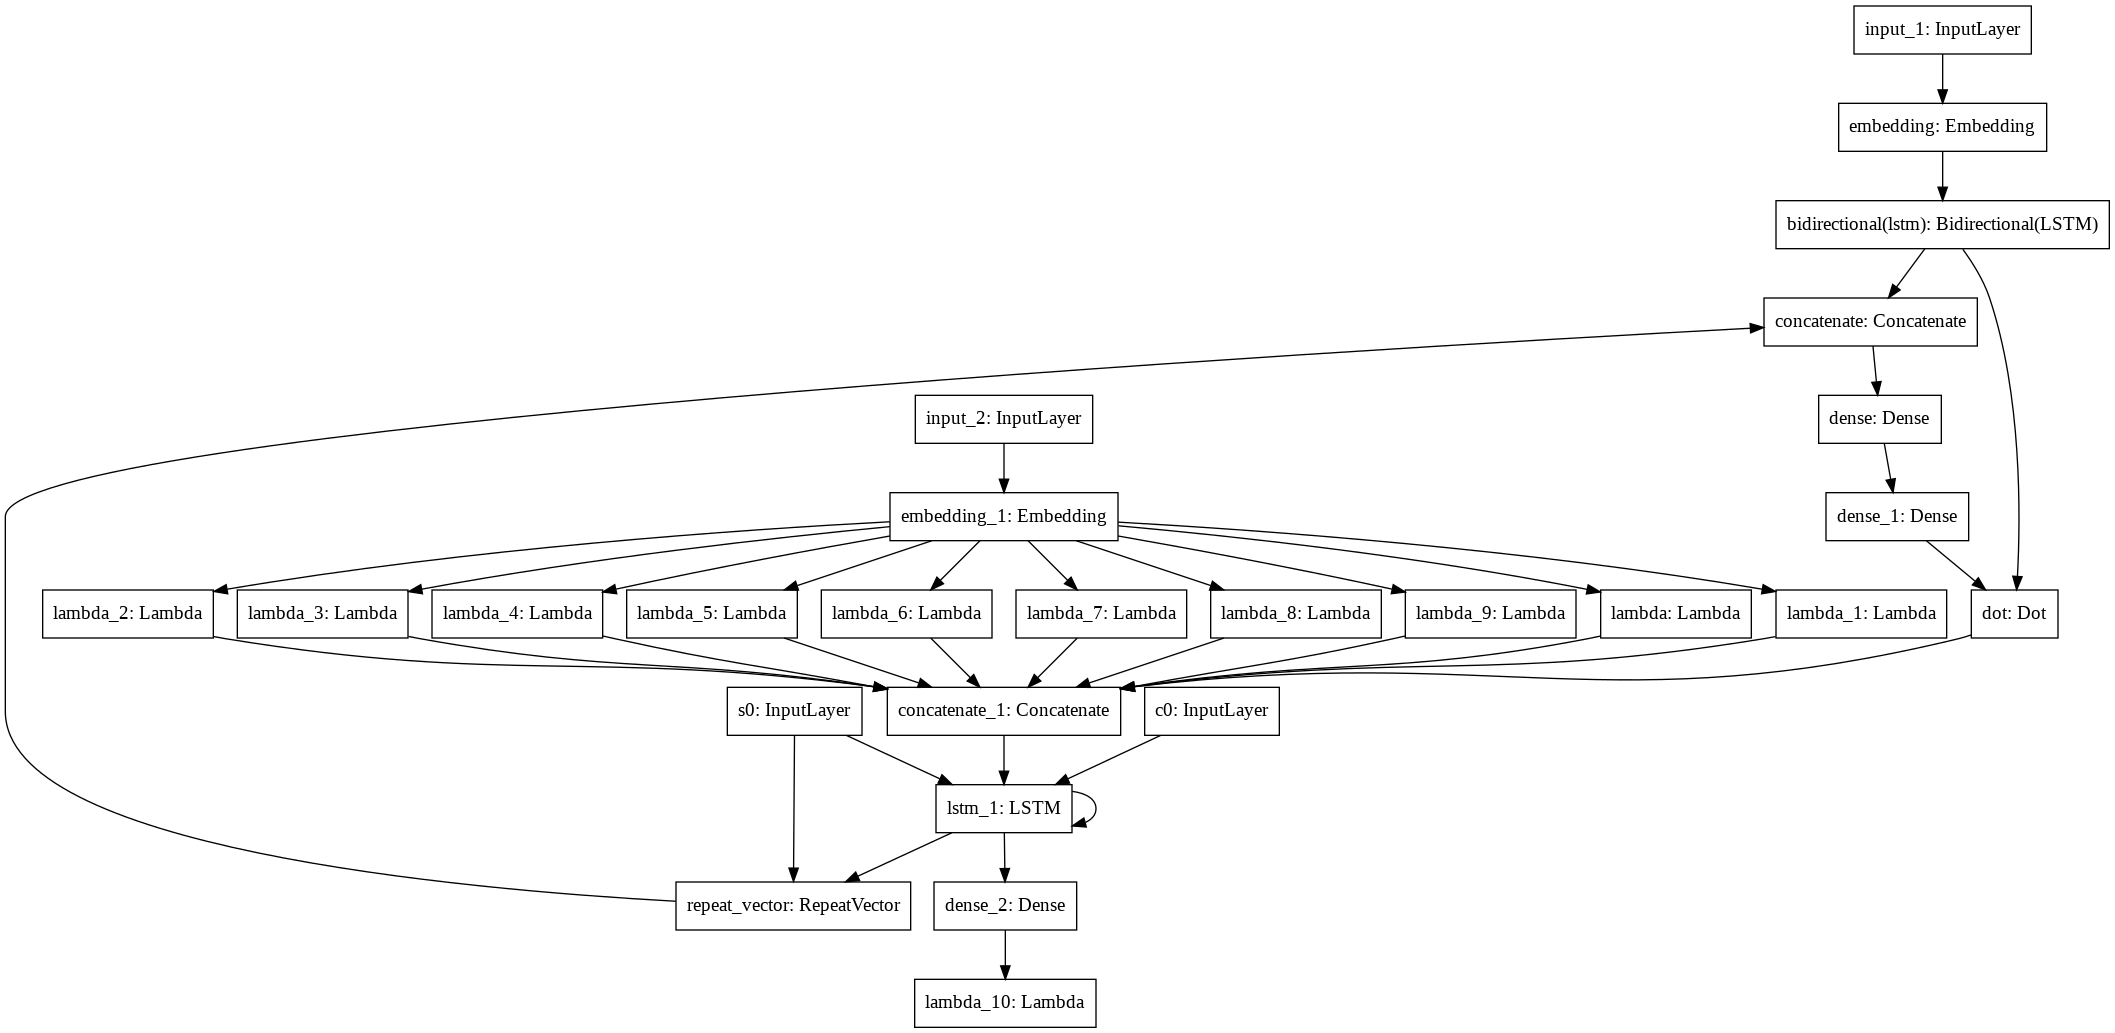

In [26]:
tf.keras.utils.plot_model(model)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6, 50)        156800      input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 1024)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 6, 2048)      8806400     embedding[0][0]                  
______________________________________________________________________________________________

In [29]:
z = np.zeros((NUM_SAMPLES, LATENT_DIM))
r = model.fit([encoder_inputs, decoder_inputs, z, z], 
              decoder_targets_one_hot, 
              batch_size=BATCH_SIZE, 
              epochs=EPOCHS, 
              validation_split=0.2, 
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min',restore_best_weights=True)],
              verbose=1)

Train on 12000 samples, validate on 3000 samples
Epoch 1/100
12000/12000 [==============================] - 46s 4ms/sample - loss: 2.4983 - accuracy: 0.6403 - val_loss: 2.6594 - val_accuracy: 0.6031
Epoch 2/100
12000/12000 [==============================] - 24s 2ms/sample - loss: 2.0647 - accuracy: 0.6759 - val_loss: 2.5158 - val_accuracy: 0.6239
Epoch 3/100
12000/12000 [==============================] - 24s 2ms/sample - loss: 1.8299 - accuracy: 0.6979 - val_loss: 2.3498 - val_accuracy: 0.6429
Epoch 4/100
12000/12000 [==============================] - 24s 2ms/sample - loss: 1.6066 - accuracy: 0.7178 - val_loss: 2.2507 - val_accuracy: 0.6543
Epoch 5/100
12000/12000 [==============================] - 24s 2ms/sample - loss: 1.4030 - accuracy: 0.7349 - val_loss: 2.1302 - val_accuracy: 0.6695
Epoch 6/100
12000/12000 [==============================] - 24s 2ms/sample - loss: 1.2235 - accuracy: 0.7503 - val_loss: 2.0819 - val_accuracy: 0.6784
Epoch 7/100
12000/12000 [==========================

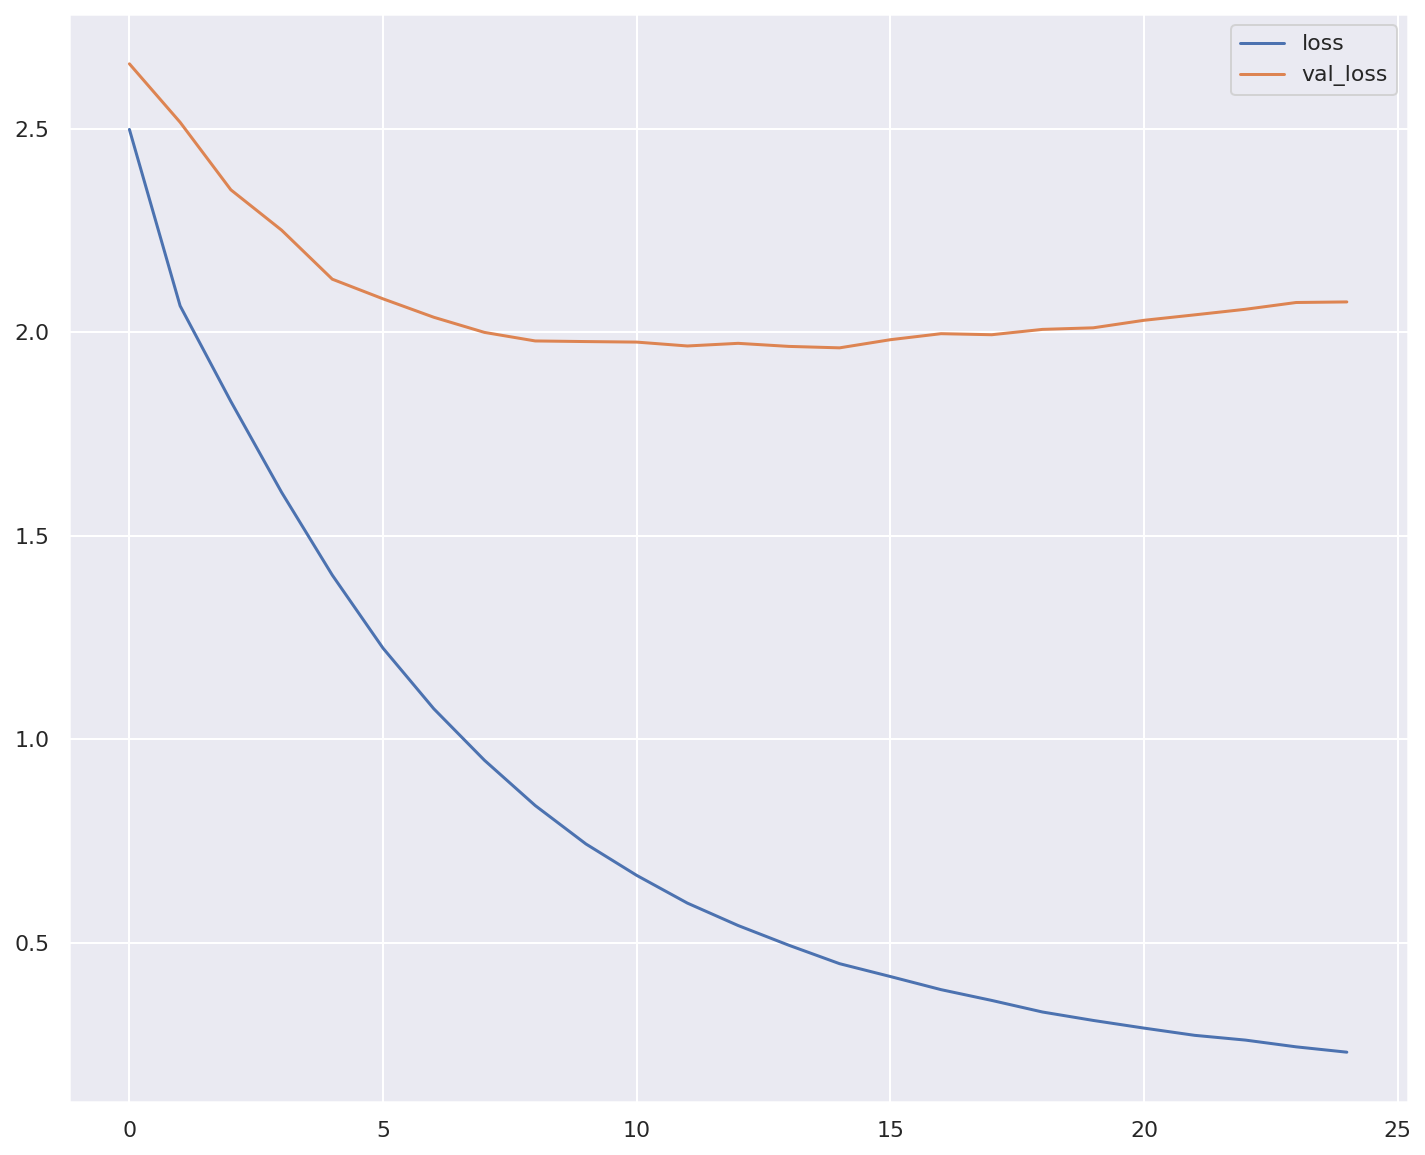

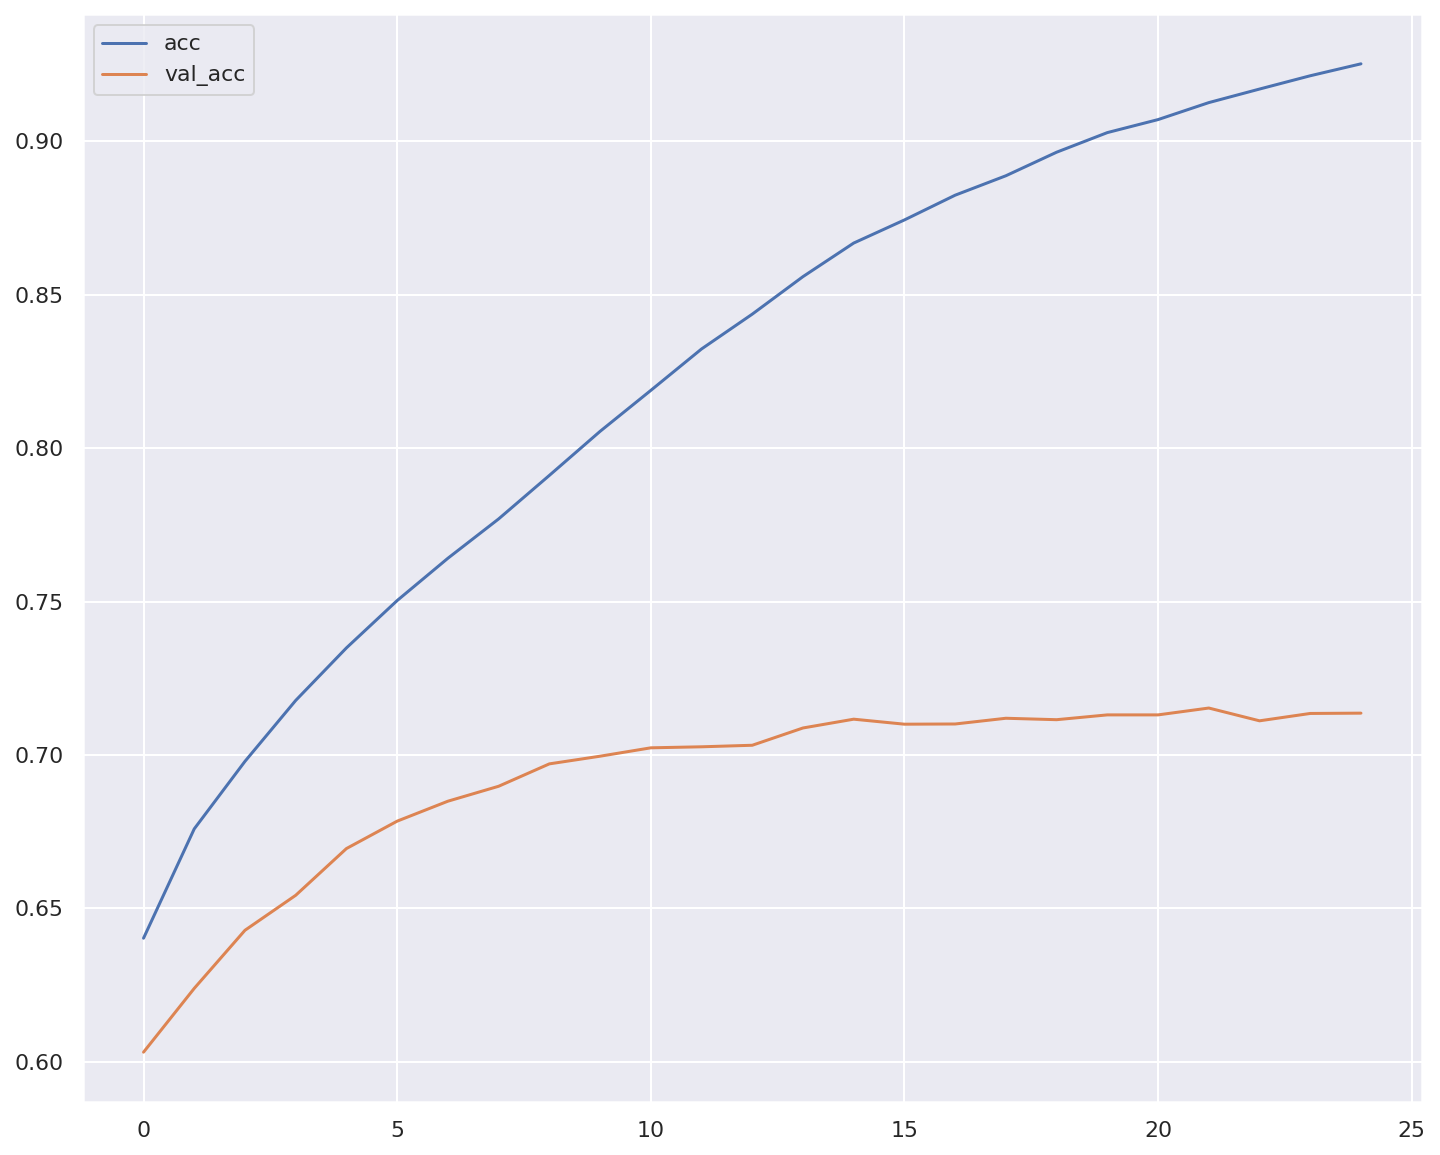

In [31]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(12,10)})

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [0]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM*2, ))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

context = one_step_attention(encoder_outputs_as_input, initial_s)

decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

decoder_model = Model(
    [decoder_inputs_single, encoder_outputs_as_input, initial_s, initial_c],
    [decoder_outputs, s, c]
)

In [0]:
idx2word_eng = {v:k for k,v in word2idx_inputs.items()}
idx2word_trans = {v:k for k,v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
  enc_out = encoder_model.predict(input_seq)

  target_seq = np.zeros((1,1))
  target_seq[0, 0] = word2idx_outputs['sos']

  eos = word2idx_outputs['eos']
  s = np.zeros((1,LATENT_DIM))
  c = np.zeros((1,LATENT_DIM))
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict(
        [target_seq, enc_out, s, c] 
    )
    idx = np.argmax(o.flatten())

    if eos == idx:
      break
    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)
    target_seq[0, 0] = idx
  return ' '.join(output_sentence)

In [38]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input: ',input_texts[i])
  print('Translation: ',translation)
  ans = input('Continue? [Y/n]')
  if ans and ans.lower().startswith('n'):
    break

-
Input:  I didn't look.
Translation:  yo no he
Continue? [Y/n]y
-
Input:  I'm beautiful.
Translation:  soy viejo
Continue? [Y/n]y
-
Input:  Who is there?
Translation:  ¿quién está ahí
Continue? [Y/n]y
-
Input:  She lives alone.
Translation:  ella vive solo
Continue? [Y/n]y
-
Input:  When do we go?
Translation:  ¿cuándo podemos ir
Continue? [Y/n]y
-
Input:  Tom was mean.
Translation:  tom era razón
Continue? [Y/n]y
-
Input:  See above.
Translation:  véase ahí
Continue? [Y/n]y
-
Input:  My cat is white.
Translation:  mi gato es blanco
Continue? [Y/n]y
-
Input:  We're right.
Translation:  hemos razón
Continue? [Y/n]y
-
Input:  I won't leave.
Translation:  no me voy
Continue? [Y/n]y
-
Input:  I do all the work.
Translation:  tengo que comprar ambos
Continue? [Y/n]y
-
Input:  I know it's hot.
Translation:  sé que está caliente
Continue? [Y/n]y
-
Input:  Go away.
Translation:  ¡vete ya
Continue? [Y/n]n
